In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path = 'drive/My Drive/cityscapes_data/'

In [3]:
import os
import cv2

In [4]:
masks = os.listdir(path + 'y_train')
original = os.listdir(path + 'x_train')

In [5]:
masks.sort()
original.sort()

In [6]:
image_height = 128
image_width = 128

In [7]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-ui4ws0i6
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-ui4ws0i6
  Running command git submodule update --init --recursive -q
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-cp37-none-any.whl size=33794 sha256=f810f96257633c65c865ac62e01bf570f4a71f32d1aa0b389efeab7a4257e84f
  Stored in directory: /tmp/pip-ephem-wheel-cache-e1u4n2_p/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models


In [8]:
import numpy as np
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Model

from segmentation_models import Unet
from segmentation_models import get_preprocessing

Segmentation Models: using `tf.keras` framework.


In [9]:
x_train = np.zeros((len(original),image_height,image_width,3),dtype=np.float32)
y_train =  np.zeros((len(masks),image_height,image_width,3),dtype=np.float32)

for file in original:
    n = original.index(file)
    path1 = os.path.join(path + 'x_train',file)
    img = cv2.imread(path1,1)
    try:
        img = cv2.resize(img,(128,128))
        x_train[n] = img/255
        file2 = masks[n]
        path2 = os.path.join(path + 'y_train',file2)
        mask = np.array(cv2.imread(path2,1))
        mask = cv2.resize(mask,(128,128))
        y_train[n] = mask/255
    except Exception as e:
        print(e)
        print(path1)

In [10]:
masks = os.listdir(path + 'y_val')
original = os.listdir(path + 'x_val')

In [11]:
masks.sort()
original.sort()

In [12]:
x_val = np.zeros((len(original),image_height,image_width,3),dtype=np.float32)
y_val = np.zeros((len(masks),image_height,image_width,3),dtype=np.float32)

for file in original:
    n = original.index(file)
    path1 = os.path.join(path + 'x_val',file)
    img = cv2.imread(path1,1)
    try:
        img = cv2.resize(img,(128,128))
        x_val[n] = img/255
        file2 = masks[n]
        path2 = os.path.join(path + 'y_val',file2)
        mask = np.array(cv2.imread(path2,1))
        mask = cv2.resize(mask,(128,128))
        y_val[n] = mask/255
    except Exception as e:
        print(e)
        print(path1)

In [13]:
backbone = 'resnet34'
preprocess_input = get_preprocessing(backbone)

In [14]:
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

In [16]:
N = x_train.shape[-1]

In [17]:
np.save('x_train',x_train)

In [18]:
np.save('y_train',y_train)
np.save('x_val',x_val)
np.save('y_val',y_val)

In [19]:
base_model = Unet(backbone_name='inceptionv3',encoder_weights='imagenet')

87916544/87910968 [==============================] - 1s 0us/step


In [26]:
inp = Input(shape=(128,128,N))
l1 = Conv2D(3,(1,1))(inp)
out = base_model(l1)
l2 = Conv2D(3,(1,1))(out)
model = Model(inp,l2,name=base_model.name)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 128, 128, 3)       12        
_________________________________________________________________
model (Model)                multiple                  29933105  
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 128, 128, 3)       6         
Total params: 29,933,123
Trainable params: 29,896,707
Non-trainable params: 36,416
_________________________________________________________________


In [27]:
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 multiple             864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma multiple             96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         multiple             0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [28]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

In [29]:
def dice_coefficient(y_true,y_pred):
    num = 2*tf.reduce_sum(y_true*y_pred)
    deno = tf.reduce_sum(y_true+y_pred)
    return num/(deno + tf.keras.backend.epsilon())

In [40]:
model.compile('Adam',loss = binary_crossentropy,metrics=[dice_coefficient])

In [41]:
import matplotlib.pyplot as plt

In [42]:
def drawImg(img):
  plt.imshow(img)
  plt.axis('off')
  plt.show()

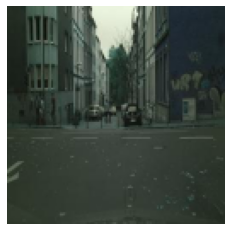

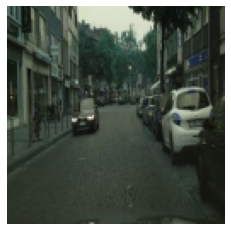

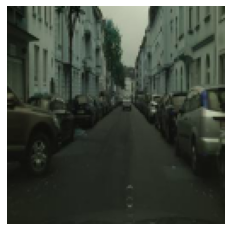

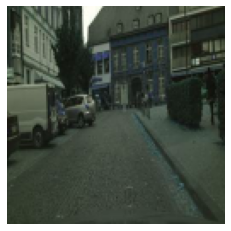

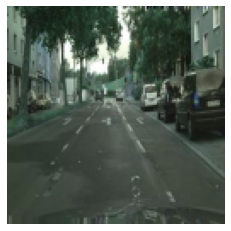

In [43]:
for i in range(5):
  drawImg(x_train[i])

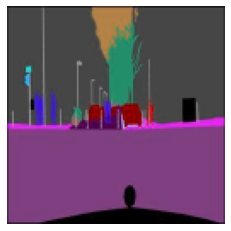

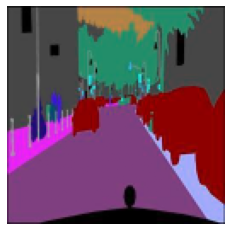

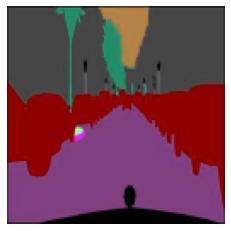

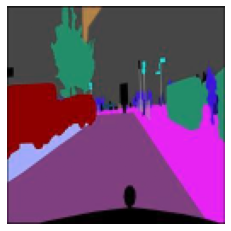

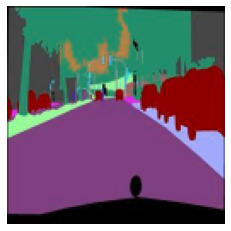

In [44]:
for i in range(5):
  drawImg(y_train[i])

In [45]:
model.fit(x=x_train,y=y_train,batch_size=64,epochs=5,validation_data=(x_val,y_val))

Train on 5950 samples, validate on 500 samples
Epoch 1/5
5950/5950 [==============================] - 2644s 444ms/sample - loss: 2.4242 - dice_coefficient: 0.2576 - val_loss: 2.3935 - val_dice_coefficient: 0.2408
Epoch 2/5
5950/5950 [==============================] - 2592s 436ms/sample - loss: 2.4234 - dice_coefficient: 0.2584 - val_loss: 2.3935 - val_dice_coefficient: 0.2427
Epoch 3/5
5950/5950 [==============================] - 2606s 438ms/sample - loss: 2.4225 - dice_coefficient: 0.2592 - val_loss: 2.3928 - val_dice_coefficient: 0.2490
Epoch 4/5
5950/5950 [==============================] - 2615s 439ms/sample - loss: 2.4217 - dice_coefficient: 0.2598 - val_loss: 2.3938 - val_dice_coefficient: 0.2461
Epoch 5/5
5950/5950 [==============================] - 2634s 443ms/sample - loss: 2.4208 - dice_coefficient: 0.2608 - val_loss: 2.3929 - val_dice_coefficient: 0.2498


In [46]:
import pickle

In [48]:
model_json = model.to_json()

In [50]:
with open('model.json','w') as json_file:
  json_file.write(model_json)

In [51]:
model.save_weights('mymodel.h5')

In [52]:
model.evaluate(x_val,y_val,verbose=1)

500/500 [==============================] - 45s 89ms/sample - loss: 2.3929 - dice_coefficient: 0.2495


[2.3929373359680177, 0.24951726]

In [53]:
pred_val = model.predict(x_val,verbose=1)

500/500 [==============================] - 48s 96ms/sample


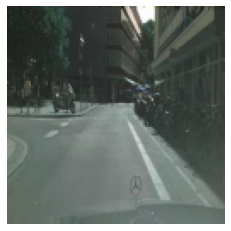

In [54]:
drawImg(x_val[7])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


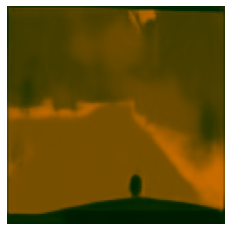

In [55]:
drawImg(pred_val[7])

In [56]:
hist = model.history

In [62]:
loss = hist.history['loss']
dc = hist.history['dice_coefficient']
loss_val = hist.history['val_loss']
dc_val = hist.history['val_dice_coefficient']

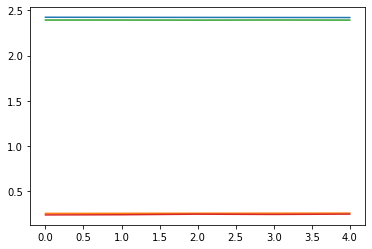

In [63]:
plt.plot(loss)
plt.plot(dc)
plt.plot(loss_val)
plt.plot(dc_val)
plt.show()